In [2]:
import numpy as np
import tensorflow as tf
import math
import cv2
import matplotlib.pyplot as plt
import time

In [3]:
def relabeling(im):
    img=im[:,:,0]
    re_img=np.zeros((img.shape[0],img.shape[1],1), np.uint8)
    re_img[np.where(img==1)]=1
    re_img[np.where(img==2)]=2
    re_img[np.where(img==20)]=2
    re_img[np.where(img==3)]=3
    re_img[np.where(img==17)]=3
    re_img[np.where(img==10)]=3
    re_img[np.where(img==15)]=3
    re_img[np.where(img==4)]=4
    re_img[np.where(img==5)]=5
    re_img[np.where(img==6)]=5
    re_img[np.where(img==7)]=6
    re_img[np.where(img==14)]=6
    re_img[np.where(img==8)]=7
    re_img[np.where(img==9)]=8
    re_img[np.where(img==13)]=9
    re_img[np.where(img==16)]=9
    re_img[np.where(img==16)]=9
    re_img[np.where(img==18)]=10
    re_img[np.where(img==19)]=11
    re_img[np.where(img==22)]=12
    re_img[np.where(img==24)]=13
    re_img[np.where(img==25)]=14
    re_img[np.where(img==23)]=15
    re_img[np.where(img==26)]=15
    re_img[np.where(img==29)]=16
    re_img[np.where(img==32)]=17
    re_img[np.where(img==35)]=17
    re_img[np.where(img==34)]=18
    re_img[np.where(img==37)]=19
    
    return re_img

In [4]:
def l_oneshot(label):
    arr=np.zeros((label[:,:,0].shape[0]*label[:,:,0].shape[1],20),np.uint8)
    flat_label=label[:,:,0].flatten()
    for x in range(len(flat_label)):
        arr[x,flat_label[x]]=1
    arr=np.reshape(arr,(label[:,:,0].shape[0],label[:,:,0].shape[1],20))
    return arr

def im_resize(img):
    im=cv2.resize(img, (96,96), interpolation=cv2.INTER_AREA)
    return im

In [4]:
def bn(layer, use_bn):
    #return tf.nn.elu(layer)
    mean, var=tf.nn.moments(layer,[0,1,2])
    layer_1=tf.nn.batch_normalization(layer,mean,var,0,1,0.0001)
    return tf.nn.relu(layer_1)
#     if use_bn==True:
#         mean, var=tf.nn.moments(layer,[0,1,2])
#         layer_1=tf.nn.batch_normalization(layer,mean,var,0,1,0.0001)
#         return tf.nn.relu(layer_1)
#     else:
#         return tf.nn.relu(layer)

In [5]:
def bn_sig(layer, use_bn):
    if use_bn==True:
        mean, var=tf.nn.moments(layer,[0,1,2])
        layer_1=tf.nn.batch_normalization(layer,mean,var,0,1,0.0001)
        return tf.nn.sigmoid(layer_1)
    else:
        return tf.nn.sigmoid(layer)

In [6]:
def bn_no(layer, use_bn):
#     mean, var=tf.nn.moments(layer,[0,1,2])
#     layer_1=tf.nn.batch_normalization(layer,mean,var,0,1,0.0001)
#     return layer_1
    if use_bn==True:
        mean, var=tf.nn.moments(layer,[0,1,2])
        layer_1=tf.nn.batch_normalization(layer,mean,var,0,1,0.0001)
        return layer_1
    else:
        return layer

In [7]:
def unravel_argmax(argmax, shape):
    output_list = []
    output_list.append(argmax // (shape[2] * shape[3]))
    output_list.append(argmax % (shape[2] * shape[3]) // shape[3])
    return tf.stack(output_list)

In [8]:
def unpool_layer(x, raveled_argmax, out_shape):
    batch = out_shape[0]
    height = out_shape[1]
    width = out_shape[2]
    channels = out_shape[3]
    one_like_mask = tf.ones_like(raveled_argmax)
    batch_range = tf.reshape(tf.to_int64(tf.range(batch)), shape=[batch, 1, 1, 1])
    b = one_like_mask * batch_range
    y = raveled_argmax // (width * channels)
    w = raveled_argmax % (width * channels) // channels
    feature_range = tf.to_int64(tf.range(channels))
    f = one_like_mask * feature_range
    # transpose indices & reshape update values to one dimension
    updates_size = tf.size(x)
    indices = tf.transpose(tf.reshape(tf.stack([b, y, w, f]), [4, updates_size]))
    values = tf.reshape(x, [updates_size])
    ret = tf.scatter_nd(indices, values, tf.to_int64(out_shape))
    return ret

In [9]:
train_label=[l_oneshot(im_resize(cv2.imread('train_label_20/img-'+str(i+1).zfill(6)+'.png'))) for i in range(5285)]#5285

In [10]:
train_image=[im_resize(cv2.imread('train_image_20/img-'+str(i+1).zfill(6)+'.jpg')) for i in range(5285)]#5285

In [11]:
test_image=[im_resize(cv2.imread('test_image_20/img-'+str(i+1).zfill(6)+'.jpg')) for i in range(2000)]#5285

In [12]:
test_label=[l_oneshot(im_resize(cv2.imread('test_label_20/img-'+str(i+1).zfill(6)+'.png'))) for i in range(2000)]

In [13]:
h=int(train_label[0].shape[0])
w=int(train_label[0].shape[1])
c=int(train_label[0].shape[2])

In [14]:
print(h,w,c)

192 192 20


In [15]:
version='30'

In [16]:
#learning_rate=0.0001
training_epochs=50
batch_size = 6
tf.reset_default_graph()
x=tf.placeholder(tf.float32,[None,h,w,3])
y=tf.placeholder(tf.float32, [None,h,w,c])
keep_prob=tf.placeholder(tf.float32)
train_type=tf.placeholder(tf.bool)

In [17]:
w_norm_1=tf.get_variable("w_norm_1", shape=[1,1,3,16], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_norm_2=tf.get_variable("w_norm_2", shape=[3,3,3,32], initializer=tf.contrib.layers.xavier_initializer_conv2d())


In [18]:
l_norm_1=bn(tf.nn.conv2d(x,w_norm_1, strides=[1,1,1,1], padding= 'SAME'),train_type)
l_norm_2=bn(tf.nn.conv2d(x,w_norm_2, strides=[1,1,1,1], padding= 'SAME'),train_type)

In [19]:
w_c_1_1=tf.get_variable("w_c_1_1", shape=[5,5,48,128], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_1_2=tf.get_variable("w_c_1_2", shape=[5,5,128,128], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_1_3=tf.get_variable("w_c_1_3", shape=[5,5,128,128], initializer=tf.contrib.layers.xavier_initializer_conv2d())



w_c_2_1=tf.get_variable("w_c_2_1", shape=[5,5,128,128], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_2_2=tf.get_variable("w_c_2_2", shape=[5,5,128,128], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_2_3=tf.get_variable("w_c_2_3", shape=[5,5,128,128], initializer=tf.contrib.layers.xavier_initializer_conv2d())



w_c_3_1=tf.get_variable("w_c_3_1", shape=[5,5,128,256], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_3_2=tf.get_variable("w_c_3_2", shape=[5,5,256,256], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_3_3=tf.get_variable("w_c_3_3", shape=[5,5,256,256], initializer=tf.contrib.layers.xavier_initializer_conv2d())


w_c_4_1=tf.get_variable("w_c_4_1", shape=[3,3,256,512], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_4_2=tf.get_variable("w_c_4_2", shape=[3,3,512,512], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_4_3=tf.get_variable("w_c_4_3", shape=[3,3,512,512], initializer=tf.contrib.layers.xavier_initializer_conv2d())


w_c_5_1=tf.get_variable("w_c_5_1", shape=[3,3,512,1024], initializer=tf.contrib.layers.xavier_initializer_conv2d())

In [20]:
b_c_1_1=tf.Variable(tf.random_normal([128]))
b_c_1_2=tf.Variable(tf.random_normal([128]))
b_c_1_3=tf.Variable(tf.random_normal([128]))

b_c_2_1=tf.Variable(tf.random_normal([128]))
b_c_2_2=tf.Variable(tf.random_normal([128]))
b_c_2_3=tf.Variable(tf.random_normal([128]))

b_c_3_1=tf.Variable(tf.random_normal([256]))
b_c_3_2=tf.Variable(tf.random_normal([256]))
b_c_3_3=tf.Variable(tf.random_normal([256]))

b_c_4_1=tf.Variable(tf.random_normal([512]))
b_c_4_2=tf.Variable(tf.random_normal([512]))
b_c_4_3=tf.Variable(tf.random_normal([512]))

b_c_5_1=tf.Variable(tf.random_normal([1024]))


In [22]:
l_input=tf.concat([l_norm_1,l_norm_2],3)
############# 1 conv layer
l_c_1_1=bn(tf.nn.conv2d(l_input,w_c_1_1, strides=[1,1,1,1], padding= 'SAME')+b_c_1_1,train_type)
l_c_1_2=bn(tf.nn.conv2d(l_c_1_1,w_c_1_2, strides=[1,1,1,1], padding= 'SAME')+b_c_1_2,train_type)
l_c_1_3=bn(tf.nn.conv2d(l_c_1_2,w_c_1_3, strides=[1,1,1,1], padding= 'SAME')+b_c_1_3,train_type)
l_c_1=tf.nn.max_pool(l_c_1_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
l_c_1=tf.layers.dropout(l_c_1,rate=keep_prob)

#############2 conv layer
l_c_2_1=bn(tf.nn.conv2d(l_c_1,w_c_2_1, strides=[1,1,1,1], padding= 'SAME')+b_c_2_1,train_type)
l_c_2_2=bn(tf.nn.conv2d(l_c_2_1,w_c_2_2, strides=[1,1,1,1], padding= 'SAME')+b_c_2_2,train_type)
l_c_2_3=bn(tf.nn.conv2d(l_c_2_2,w_c_2_3, strides=[1,1,1,1], padding= 'SAME')+b_c_2_3,train_type)
l_c_2=tf.nn.max_pool(l_c_2_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
l_c_2=tf.layers.dropout(l_c_2,rate=keep_prob)

#############3 conv layer
l_c_3_1=bn(tf.nn.conv2d(l_c_2,w_c_3_1, strides=[1,1,1,1], padding= 'SAME')+b_c_3_1,train_type)
l_c_3_2=bn(tf.nn.conv2d(l_c_3_1,w_c_3_2, strides=[1,1,1,1], padding= 'SAME')+b_c_3_2,train_type)
l_c_3_3=bn(tf.nn.conv2d(l_c_3_2,w_c_3_3, strides=[1,1,1,1], padding= 'SAME')+b_c_3_3,train_type)
l_c_3=tf.nn.max_pool(l_c_3_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
l_c_3=tf.layers.dropout(l_c_3,rate=keep_prob)

#############4 conv layer
l_c_4_1=bn(tf.nn.conv2d(l_c_3,w_c_4_1, strides=[1,1,1,1], padding= 'SAME')+b_c_4_1,train_type)
l_c_4_2=bn(tf.nn.conv2d(l_c_4_1,w_c_4_2, strides=[1,1,1,1], padding= 'SAME')+b_c_4_2,train_type)
l_c_4_3=bn(tf.nn.conv2d(l_c_4_2,w_c_4_3, strides=[1,1,1,1], padding= 'SAME')+b_c_4_3,train_type)
l_c_4=tf.nn.max_pool(l_c_4_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
l_c_4=tf.layers.dropout(l_c_4,rate=keep_prob)

l_c_5=tf.nn.relu(tf.nn.conv2d(l_c_4,w_c_5_1, strides=[1,1,1,1], padding= 'SAME')+b_c_5_1)
l_c_5=tf.layers.dropout(l_c_5,rate=keep_prob)

In [23]:
w_c_4_4_1=tf.get_variable("w_c_4_4_1", shape=[3,3,512,512], initializer=tf.contrib.layers.xavier_initializer_conv2d())

w_c_3_4_1=tf.get_variable("w_c_3_4_1", shape=[3,3,256,256], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_3_4_2=tf.get_variable("w_c_3_4_2", shape=[3,3,256,256], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_c_3_4_3=tf.get_variable("w_c_3_4_3", shape=[3,3,256,256], initializer=tf.contrib.layers.xavier_initializer_conv2d())


In [24]:
b_c_4_4_1=tf.Variable(tf.random_normal([512]))

b_c_3_4_1=tf.Variable(tf.random_normal([256]))
b_c_3_4_2=tf.Variable(tf.random_normal([256]))
b_c_3_4_3=tf.Variable(tf.random_normal([256]))


In [25]:
l_c_4_4=bn(tf.nn.conv2d(l_c_4_3,w_c_4_4_1, strides=[1,1,1,1], padding= 'SAME')+b_c_4_4_1,train_type)
l_c_4_4=tf.layers.dropout(l_c_4_4,rate=keep_prob)

l_c_3_4_1=bn(tf.nn.conv2d(l_c_3_3,w_c_3_4_1, strides=[1,1,1,1], padding= 'SAME')+b_c_3_4_1,train_type)
l_c_3_4_2=bn(tf.nn.conv2d(l_c_3_4_1,w_c_3_4_2, strides=[1,1,1,1], padding= 'SAME')+b_c_3_4_2,train_type)
l_c_3_4=bn(tf.nn.conv2d(l_c_3_4_2,w_c_3_4_3, strides=[1,1,1,1], padding= 'SAME')+b_c_3_4_3,train_type)
l_c_3_4=tf.layers.dropout(l_c_3_4,rate=keep_prob)

In [26]:
# w_d_5=tf.get_variable("w_d_5", shape=[3,3,512,1024], initializer=tf.contrib.layers.xavier_initializer_conv2d())
# w_d_4_1=tf.get_variable("w_d_4_1", shape=[3,3,512,1024], initializer=tf.contrib.layers.xavier_initializer_conv2d())
# w_d_3_1=tf.get_variable("w_d_3_1", shape=[5,5,256,1280], initializer=tf.contrib.layers.xavier_initializer_conv2d())
# w_d_2_1=tf.get_variable("w_d_2_1", shape=[5,5,128,768], initializer=tf.contrib.layers.xavier_initializer_conv2d())
# w_d_1_1=tf.get_variable("w_d_1_1", shape=[5,5,128,512], initializer=tf.contrib.layers.xavier_initializer_conv2d())


w_d_5_1=tf.get_variable("w_d_5_1", shape=[3,3,512,1024], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_d_5_2=tf.get_variable("w_d_5_2", shape=[3,3,512,512], initializer=tf.contrib.layers.xavier_initializer_conv2d())


w_d_4_1=tf.get_variable("w_d_4_1", shape=[3,3,512,1536], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_d_4_2=tf.get_variable("w_d_4_2", shape=[3,3,512,512], initializer=tf.contrib.layers.xavier_initializer_conv2d())


w_d_3_1=tf.get_variable("w_d_3_1", shape=[3,3,256,1280], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_d_3_2=tf.get_variable("w_d_3_2", shape=[3,3,256,256], initializer=tf.contrib.layers.xavier_initializer_conv2d())


w_d_2_1=tf.get_variable("w_d_2_1", shape=[5,5,128,512], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_d_2_2=tf.get_variable("w_d_2_2", shape=[5,5,128,128], initializer=tf.contrib.layers.xavier_initializer_conv2d())


w_d_1_1=tf.get_variable("w_d_1_1", shape=[5,5,128,256], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_d_1_2=tf.get_variable("w_d_1_2", shape=[5,5,128,128], initializer=tf.contrib.layers.xavier_initializer_conv2d())

In [27]:
#############5 deconv layer
l_d_5_1=tf.nn.conv2d_transpose(l_c_5,w_d_5_1,tf.stack([tf.shape(x)[0],math.ceil(h/16),math.ceil(w/16),512]),strides=[1,1,1,1],padding='SAME')
l_d_5_2=tf.nn.conv2d_transpose(l_d_5_1,w_d_5_2,tf.stack([tf.shape(x)[0],math.ceil(h/16),math.ceil(w/16),512]),strides=[1,1,1,1],padding='SAME')
l_d_5_3=tf.nn.avg_pool(l_d_5_2, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
l_d_5=tf.concat([l_d_5_3,l_d_5_3],3)
l_d_5=tf.layers.dropout(l_d_5,rate=keep_prob)

#############4 deconv layer
l_d_4_1=tf.image.resize_images(l_d_5,[math.ceil(h/8),math.ceil(w/8)],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
l_d_4_2=tf.concat([l_d_4_1,l_c_4_4],3)
l_d_4_3=bn(tf.nn.conv2d_transpose(l_d_4_2,w_d_4_1,tf.stack([tf.shape(x)[0],int(math.ceil(h/8)),int(math.ceil(w/8)),512]),strides=[1,1,1,1],padding='SAME'),train_type)
l_d_4_5=bn(tf.nn.conv2d_transpose(l_d_4_3,w_d_4_2,tf.stack([tf.shape(x)[0],int(math.ceil(h/8)),int(math.ceil(w/8)),512]),strides=[1,1,1,1],padding='SAME'),train_type)
#l_d_4_5=bn(tf.nn.conv2d_transpose(l_d_4_4,w_d_4_3,tf.stack([tf.shape(x)[0],int(math.ceil(h/8)),int(math.ceil(w/8)),512]),strides=[1,1,1,1],padding='SAME'),train_type)
l_d_4_6=tf.nn.avg_pool(l_d_4_5, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
l_d_4=tf.concat([l_d_4_5,l_d_4_6],3)
l_d_4=tf.layers.dropout(l_d_4,rate=keep_prob)


#############3 deconv layer
l_d_3_1=tf.image.resize_images(l_d_4,[int(math.ceil(h/4)),int(math.ceil(w/4))],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
l_d_3_2=tf.concat([l_d_3_1,l_c_3_4],3)
l_d_3_3=bn(tf.nn.conv2d_transpose(l_d_3_2,w_d_3_1,tf.stack([tf.shape(x)[0],int(math.ceil(h/4)),int(math.ceil(w/4)),256]),strides=[1,1,1,1],padding='SAME'),train_type)
l_d_3_5=bn(tf.nn.conv2d_transpose(l_d_3_3,w_d_3_2,tf.stack([tf.shape(x)[0],int(math.ceil(h/4)),int(math.ceil(w/4)),256]),strides=[1,1,1,1],padding='SAME'),train_type)
#l_d_3_5=bn(tf.nn.conv2d_transpose(l_d_3_4,w_d_3_3,tf.stack([tf.shape(x)[0],int(math.ceil(h/4)),int(math.ceil(w/4)),256]),strides=[1,1,1,1],padding='SAME'),train_type)
l_d_3_6=tf.nn.avg_pool(l_d_3_5, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
l_d_3=tf.concat([l_d_3_5,l_d_3_6],3)
l_d_3=tf.layers.dropout(l_d_3,rate=keep_prob)

#############2 deconv layer
l_d_2_2=tf.image.resize_images(l_d_3,[int(math.ceil(h/2)),int(math.ceil(w/2))],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
l_d_2_3=bn(tf.nn.conv2d_transpose(l_d_2_2,w_d_2_1,tf.stack([tf.shape(x)[0],int(math.ceil(h/2)),int(math.ceil(w/2)),128]),strides=[1,1,1,1],padding='SAME'),train_type)
l_d_2_5=bn(tf.nn.conv2d_transpose(l_d_2_3,w_d_2_2,tf.stack([tf.shape(x)[0],int(math.ceil(h/2)),int(math.ceil(w/2)),128]),strides=[1,1,1,1],padding='SAME'),train_type)
#l_d_2_5=bn(tf.nn.conv2d_transpose(l_d_2_4,w_d_2_3,tf.stack([tf.shape(x)[0],int(math.ceil(h/2)),int(math.ceil(w/2)),128]),strides=[1,1,1,1],padding='SAME'),train_type)
l_d_2_6=tf.nn.avg_pool(l_d_2_5, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
l_d_2=tf.concat([l_d_2_5,l_d_2_6],3)
l_d_2=tf.layers.dropout(l_d_2,rate=keep_prob)

#############1 deconv layer
l_d_1_2=tf.image.resize_images(l_d_2,[h,w],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
l_d_1_3=bn(tf.nn.conv2d_transpose(l_d_1_2,w_d_1_1,tf.stack([tf.shape(x)[0],h,w,128]),strides=[1,1,1,1],padding='SAME'),train_type)
l_d_1_5=bn(tf.nn.conv2d_transpose(l_d_1_3,w_d_1_2,tf.stack([tf.shape(x)[0],h,w,128]),strides=[1,1,1,1],padding='SAME'),train_type)
#l_d_1_5=bn(tf.nn.conv2d_transpose(l_d_1_4,w_d_1_3,tf.stack([tf.shape(x)[0],h,w,128]),strides=[1,1,1,1],padding='SAME'),train_type)
l_d_1_6=tf.nn.avg_pool(l_d_1_5, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')
l_d_1=tf.concat([l_d_1_5,l_d_1_6],3)
l_d_1=tf.layers.dropout(l_d_1,rate=keep_prob)

In [28]:
# w_edge_1=tf.get_variable("w_edge_1", shape=[1,1,3,16], initializer=tf.contrib.layers.xavier_initializer_conv2d())
# w_edge_2=tf.get_variable("w_edge_2", shape=[3,3,3,16], initializer=tf.contrib.layers.xavier_initializer_conv2d())


# l_edge_1=bn_sig(tf.nn.conv2d(x,w_edge_1,strides=[1,1,1,1],padding='SAME'),train_type)
# l_edge_2=bn_sig(tf.nn.conv2d(x,w_edge_2,strides=[1,1,1,1],padding='SAME'),train_type)

# l_edge=tf.concat([l_edge_1,l_edge_2],3)

In [29]:
w_soft_1=tf.get_variable("w_soft_1", shape=[1,1,256,1024], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_soft_2=tf.get_variable("w_soft_2", shape=[1,1,1024,512], initializer=tf.contrib.layers.xavier_initializer_conv2d())
w_soft_3=tf.get_variable("w_soft_3", shape=[1,1,512,c], initializer=tf.contrib.layers.xavier_initializer_conv2d())


b_soft_1=tf.Variable(tf.random_normal([1024]))
b_soft_2=tf.Variable(tf.random_normal([512]))
b_soft_3=tf.Variable(tf.random_normal([c]))





In [30]:
l_soft_1=tf.nn.relu(tf.nn.conv2d(l_d_1,w_soft_1, strides=[1,1,1,1], padding= 'SAME')+b_soft_1)
l_soft_2=tf.nn.relu(tf.nn.conv2d(l_soft_1,w_soft_2, strides=[1,1,1,1], padding= 'SAME')+b_soft_2)
target=tf.nn.conv2d(l_soft_2,w_soft_3, strides=[1,1,1,1], padding= 'SAME')+b_soft_3
#l_soft_4=bn(tf.nn.max_pool(l_soft_3, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME'),train_type)
#target=tf.nn.conv2d(l_soft_3,w_soft_4, strides=[1,1,1,1], padding= 'SAME')+b_soft_4


In [31]:
l_c=tf.nn.conv2d(l_c_4,w_c_5_1, strides=[1,1,1,1], padding= 'SAME')+b_c_5_1
c_mean, c_var=tf.nn.moments(l_c,[0,1,2])

regular=tf.square(c_mean)+tf.square(c_var)-1-tf.log(tf.square(c_var))
reg_cost=tf.reduce_sum(regular)/2

In [32]:
print(reg_cost)

Tensor("truediv:0", shape=(), dtype=float32)


In [33]:
flat_output=tf.reshape(target,[-1,c])
flat_y=tf.reshape(y,[-1,c])

In [34]:
soft=tf.nn.softmax(flat_output)

In [35]:
image=tf.argmax(target,3)
y_image=tf.argmax(y,3)

In [36]:
soft_max=tf.reduce_max(soft,1)
soft_max=tf.reshape(soft_max,[-1,1])

max_softmax_t=(soft//soft_max)*soft
# max_softmax_f=(soft//soft_max)*(1-soft)
max_softmax_f=soft-max_softmax_t

soft_t=(soft//soft_max)
soft_f=1-soft_t


In [37]:
soft_x_t=flat_y*max_softmax_t
soft_x_f=flat_y*max_softmax_f
soft_x_t_max=tf.reduce_sum(soft_x_t,1)
f_soft_1=tf.ones_like(soft_x_f)*1.2
f_soft=tf.pow(soft_x_f,f_soft_1)
soft_x_f_max=tf.reduce_sum(f_soft,1)

soft_x_max=soft_x_t_max+soft_x_f_max

cost_x=-tf.log(soft_x_max)
re_x_cost=tf.reshape(cost_x,[-1,h*w])
each_x_cost=tf.reduce_mean(re_x_cost,1)
x_cost=tf.reduce_mean(each_x_cost)

In [38]:
# t_label=flat_y*soft_t
# f_label=flat_y*soft_f
# f_soft_1=tf.ones_like(soft)*1.2
# f_soft=tf.pow(soft,f_soft_1)
# x_t_cost=tf.nn.softmax_cross_entropy_with_logits(logits=soft,labels=t_label)
# x_f_cost=tf.nn.softmax_cross_entropy_with_logits(logits=f_soft,labels=f_label)
# x_t_cost=tf.reshape(x_t_cost,[-1,1])
# x_f_cost=tf.reshape(x_f_cost,[-1,1])
# x_cost=x_t_cost+x_f_cost

# x_cost=tf.reshape(x_cost,[-1,h*w])
# x_cost=tf.reduce_mean(x_cost,1)
# x_cost=tf.reduce_mean(x_cost)

In [39]:
mod_y=1-flat_y
soft_y=mod_y*soft
e_map=tf.reduce_max(soft_y,1)
e_map=tf.reshape(e_map,[-1,1])

cost_y=tf.exp(e_map)
re_cost_y=tf.reshape(cost_y,[-1,h*w])
mod_cost=tf.reduce_mean(re_cost_y,1)
y_cost=tf.reduce_mean(mod_cost)


In [40]:
cost=x_cost+y_cost+reg_cost

#cost=x_cost

In [41]:
learning_rate=tf.train.exponential_decay(0.0001,batch_size*batch_size,1000,0.9,staircase=True)
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [42]:
# learning_rate_1=tf.train.exponential_decay(0.00001,batch_size*batch_size,1000,0.9,staircase=True)
# optimizer_1=tf.train.AdamOptimizer(learning_rate=learning_rate_1).minimize(y_cost)

In [43]:
max_output=tf.reduce_max(soft,1)
max_output=tf.reshape(max_output,[-1,1])

iou=soft//max_output

inter=iou*flat_y
union=iou+flat_y
union_1=tf.ones_like(union)
union_2=tf.minimum(union_1,union)

inter_sum=tf.reduce_sum(inter,0)
union_sum=tf.reduce_sum(union_2,0)

union_sum_1=tf.ones_like(union_sum)
union_sum_2=tf.maximum(union_sum_1,union_sum)
iou_acc=tf.div(inter_sum,union_sum_2)

mean_sum=tf.reduce_sum(flat_y,0)
mean_sum_1=tf.ones_like(mean_sum)
mean_sum_2=tf.maximum(mean_sum_1,mean_sum)
mean_acc=tf.div(inter_sum,mean_sum_2)

In [44]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

saver=tf.train.Saver()
#saver.restore(sess,"output"+version+"/seg_model.ckpt")
print("Learning start")
for epoch in range(training_epochs):
    a=0
    total_batch = math.ceil(len(train_image)/batch_size)
    start=time.time()
    avg_cost=0
    avg_x_cost=0
    avg_y_cost=0
    avg_r_cost=0
    avg_iou_acc=np.zeros((c))
    avg_mean_acc=np.zeros((c))
    mean_iou_acc=0
    mean_mean_acc=0
    
    total_inter_sum=np.zeros((c))
    total_union_sum=np.zeros((c))
    total_mean_sum=np.zeros((c))

    for i in range(total_batch):
        if a+batch_size>len(train_image):
            batch_xs=train_image[a:]
            batch_ys=train_label[a:]
        else:
            batch_xs=train_image[a:a+batch_size]
            batch_ys=train_label[a:a+batch_size]
        feed_dict={x:batch_xs, y:batch_ys, keep_prob:0.6,train_type:True}
        rate,i_sum,u_sum,m_sum,y_img,img,l,x_c,y_c,r_c,_=sess.run([learning_rate,inter_sum,union_sum_2,mean_sum_2,y_image,image,cost,x_cost,y_cost,reg_cost,optimizer], feed_dict=feed_dict)
        for j in range(len(batch_xs)):
            plt.imsave('output'+version+'/output_img-'+str(a+j+1).zfill(6)+'.jpg',img[j])
            plt.imsave('output'+version+'/output_img-'+str(a+j+1).zfill(6)+'_y.jpg',y_img[j])
        a=a+batch_size
        avg_cost+=l
        avg_x_cost+=x_c
        avg_y_cost+=y_c
        avg_r_cost+=r_c
        for l in range(c):
            total_inter_sum[l]+=i_sum[l]
            total_union_sum[l]+=u_sum[l]
            total_mean_sum[l]+=m_sum[l]
        #print(x_c,y_c,r_c)

    print("epoch : ", epoch,"loss : ", avg_cost/total_batch,"x_cost : ",avg_x_cost/total_batch,"y_cost : ",avg_y_cost/total_batch,"r_cost : ",avg_r_cost/total_batch,"learning rate : ",rate)
    avg_iou_acc=total_inter_sum/total_union_sum
    avg_mean_acc=total_inter_sum/total_mean_sum

    
    for m in range(c):
        mean_iou_acc+=avg_iou_acc[m]
        mean_mean_acc+=avg_mean_acc[m]
    print("mean_iou_acc : ", mean_iou_acc/c)        
    print("mean_mean_acc : ", mean_mean_acc/c)
    
    
    saver.save(sess, "output"+version+"/seg_model.ckpt")
    end=time.time()
    print(end-start)
    
    if epoch%2==0:
        test_a=0
        test_batch_size=4
        test_total_batch = int(math.ceil(len(test_image)/test_batch_size))
        test_avg_cost=0
        test_avg_x_cost=0
        test_avg_y_cost=0
        test_avg_r_cost=0
        test_avg_iou_acc=np.zeros((c))
        test_avg_mean_acc=np.zeros((c))
        test_mean_iou_acc=0
        test_mean_mean_acc=0
        
        test_total_inter_sum=np.zeros((c))
        test_total_union_sum=np.zeros((c))
        test_total_mean_sum=np.zeros((c))

        for i in range(test_total_batch):
            if test_a+batch_size>len(test_image):
                test_batch_xs=test_image[test_a:]
                test_batch_ys=test_label[test_a:]
            else:
                test_batch_xs=test_image[test_a:test_a+batch_size]
                test_batch_ys=test_label[test_a:test_a+batch_size]
            test_feed_dict={x:test_batch_xs,y:test_batch_ys, keep_prob:1.0,train_type:False}
            test_i_sum,test_u_sum,test_m_sum,test_y_img,test_img,test_cost,test_x_cost,test_y_cost,test_r_cost=sess.run([inter_sum,union_sum_2,mean_sum_2,y_image,image,cost,x_cost,y_cost,reg_cost],feed_dict=test_feed_dict)

            for k in range(test_batch_size):
                plt.imsave('output'+version+'/test_image/test_img-'+str(test_a+k+1).zfill(6)+'.png',test_img[k])
                plt.imsave('output'+version+'/test_image/test_img-'+str(test_a+k+1).zfill(6)+'_y.png',test_y_img[k])
            test_a=test_a+test_batch_size
            test_avg_cost+=test_cost
            test_avg_x_cost+=test_x_cost
            test_avg_y_cost+=test_y_cost
            test_avg_r_cost+=test_r_cost
            for l in range(c):
                test_total_inter_sum[l]+=test_i_sum[l]
                test_total_union_sum[l]+=test_u_sum[l]
                test_total_mean_sum[l]+=test_m_sum[l]
        print("\n")
        print("test_cost : ",test_avg_cost/test_total_batch,"test_x_cost : ",test_avg_x_cost/test_total_batch,"test_y_cost : ",test_avg_y_cost/test_total_batch,"test_r_cost : ",test_avg_r_cost/test_total_batch)
        
        
        test_avg_iou_acc=test_total_inter_sum/test_total_union_sum
        test_avg_mean_acc=test_total_inter_sum/test_total_mean_sum
        
        
        for m in range(c):
            test_mean_iou_acc+=test_avg_iou_acc[m]
            test_mean_mean_acc+=test_avg_mean_acc[m]
        print("test_mean_iou_acc : ",test_mean_iou_acc/c)        
        print("test_mean_mean_acc : ", test_mean_mean_acc/c)

        if epoch%5==0:
            print(test_avg_iou_acc)
            print(test_avg_mean_acc)
        print("\n")

Learning start
epoch :  0 loss :  13.9832129776 x_cost :  2.17672626791 y_cost :  1.30015974053 r_cost :  10.5063269349 learning rate :  0.0001
mean_iou_acc :  0.0668487599702
mean_mean_acc :  0.11012012656
1154.7177715301514


test_cost :  5.71498812294 test_x_cost :  2.19723685241 test_y_cost :  1.28636581802 test_r_cost :  2.2313854723
test_mean_iou_acc :  0.0653136269736
test_mean_mean_acc :  0.116088119838
[ 0.13964518  0.38223872  0.43923521  0.          0.          0.17676381
  0.14184536  0.          0.02654427  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.        ]
[ 0.1938365   0.63378318  0.80814978  0.          0.          0.43939585
  0.21365546  0.          0.03294163  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.        ]


epoch :  1 loss :  5.04146740223 x_cost :  2.11378021313 y_cost :  1.29615730149 r_cost :  1.63152988937 learni

In [36]:
print("epoch : ", epoch,"loss : ", avg_cost/total_batch,"x_t_cost : ",avg_x_t_cost/total_batch,"x_f_cost : ",avg_x_f_cost/total_batch,"f_cost : ",avg_f_cost/total_batch,"learning rate : ",rate)

epoch :  0 loss :  84.6703459239 x_t_cost :  1.78157830491 x_f_cost :  79.9185226371 f_cost :  2.97024502697 learning rate :  0.00873837


In [46]:
feed_dict={x:batch_xs, y:batch_ys, keep_prob:1.0}
l1img,l2img,l3img,l4img,l5img,l6img=sess.run([l1_1,l2_1,l3_1,l4_1,l5_1,l6_1], feed_dict=feed_dict)

In [50]:
print(l1img[0,:,:,0].shape)

(224, 224)


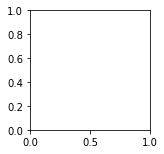

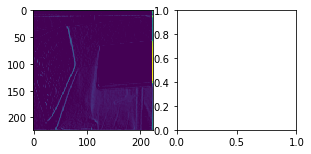

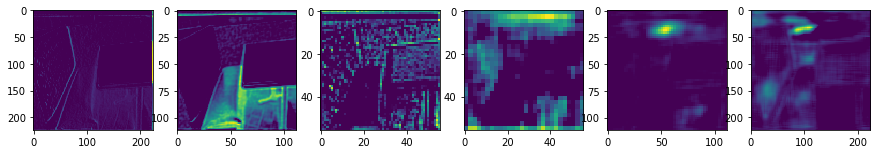

In [52]:
plt.figure(figsize=(15,15))
plt.subplot(1,6,1); plt.imshow(l1img[0,:,:,0])
plt.subplot(1,6,2); plt.imshow(l2img[0,:,:,0])
plt.subplot(1,6,3); plt.imshow(l3img[0,:,:,0])
plt.subplot(1,6,4); plt.imshow(l4img[0,:,:,0])
plt.subplot(1,6,5); plt.imshow(l5img[0,:,:,0])
plt.subplot(1,6,6); plt.imshow(l6img[0,:,:,0])
plt.show()

In [ ]:
# sess=tf.Session()
# sess.run(tf.global_variables_initializer())
# saver=tf.train.Saver()

# saver.restore(sess,"output7/seg7_model.ckpt")


a=0

total_batch = int(math.ceil(len(test_image)/batch_size))
for i in range(total_batch):
    if a+batch_size>len(test_image):
        batch_xs=test_image[a:]
        batch_ys=test_label[a:]
    else:
        batch_xs=test_image[a:a+batch_size]
        batch_ys=test_label[a:a+batch_size]
    feed_dict={x:batch_xs, y:batch_ys}
    x_img,y_img,img=sess.run([x,y_image,image], feed_dict=feed_dict)
    a=a+batch_size
    if i%10==1:
        plt.imshow(x_img[0])
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1); plt.imshow(y_img[0])
        plt.subplot(1,2,2); plt.imshow(img[0])
        plt.show()


In [ ]:
label_image=[im_resize(cv2.imread('data/train_labels/img13labels-'+str(i+1).zfill(6)+'.png')) for i in range(500)]#5285
output_image=[cv2.imread('output7/output_img-'+str(i+1).zfill(6)+'.jpg') for i in range(500)]#5285
for i in range(500):
    if i %50:
        plt.figure(figsize=(15,15))
        y_im=np.minimum(label_image[i][:,:,0],255)
        im1=np.minimum(output_image[i][:,:,0],255)
        plt.subplot(1,2,1); plt.imshow(y_im)       
        plt.subplot(1,2,2); plt.imshow(im1)
        plt.show()

In [1]:
cor_pre=tf.equal(tf.arg_max(output,1),tf.arg_max(y,1))
acc_=tf.reduce_mean(tf.cast(cor_pre,tf.float32))
feed_dict={x1:test_image, y:test_label, keep_conv:0.8, keep_hidden:0.5}
test_acc=sess.run(acc_,feed_dict=feed_dict)
print("accuracy : ", test_acc)

NameError: name 'tf' is not defined